# **Getting Started**

1. Click the down arrow on the top right corner. Change the Runtime Type to T4 GPU.

2. At any point when your GPU is running out of resources, hit Runtime on the top and Restart session. Remember to load all required libraries again.

3. Objectives of this workshop:

    1. Learn basic LLM pipeline (e.g., zero-shot learning on sentiment detection)
    2. Learn how to fine-tune a pre-trained LLM for text classification.
    3. (optional) Learn prompt engineering with LLM for text generation.
    4. Best practices on using LLMs for social science research.   

4. The Transformers library will provide access to pre-trained language models as well as an easy to use pipeline for classification.

    Read the [Transformers documentation](https://huggingface.co/docs/transformers/index)

    Explore the [repository of pre-trained models](https://huggingface.co/models)

# **Section 1: The Basics**

*    Large Language Models (LLMs) are neural network–based language models that map text to high-dimensional numeric vectors and are pretrained on massive corpora to predict the next token. This training gives broad linguistic competence and world-knowledge priors; models can be adapted via prompting, fine-tuning, or small task-specific examples.

*    LLMs perform classification, summarization, translation, question answering, and controlled generation. Outputs are probabilistic and prompt-sensitive—they reflect learned patterns rather than guaranteed facts.

**To illustrate what LLMs do under-the-hood, let's first start with what word embeddings look like.**




In [5]:
# load required libraries
import pandas as pd
import torch
from transformers import (pipeline, AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, get_scheduler, AutoModelForCausalLM)
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from datasets import Dataset
from torch.utils.data import DataLoader

We want to make sure we are using a GPU that is running cuda for fast inference. So here we quickly check to see if one is available. If this prints 'cpu' rather than 'cuda' then change the runtime at the top if running this notebook in collab or double check your computing environment otherwise.

In [ ]:
# use GPU if one is available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [ ]:
# Load a small LLM model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Words or short phrases to embed
words = ["cat", "apple", "queen", "king"]

# Get word embeddings (encoding)
embeddings = model.encode(words)

In [ ]:
print(embeddings.shape)  # (4, 384) -> 4 words, 384 dimensions for each
print(embeddings[0])        # show the actual word vectors for "cat"

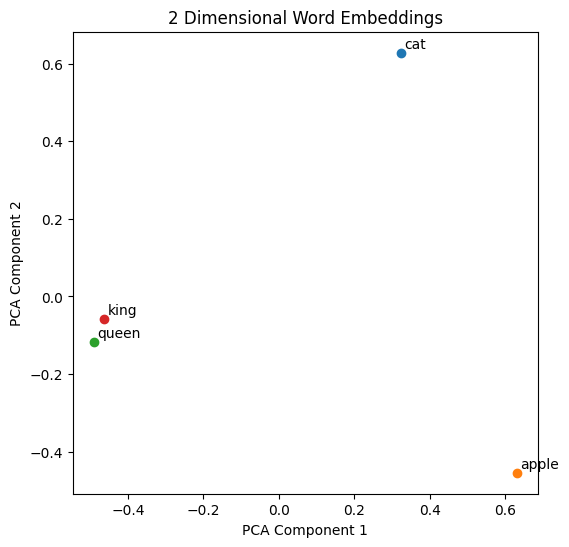

In [ ]:
# visualize the words in a 2-D space
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

# Plot the words
plt.figure(figsize=(6, 6))
for word, (x, y) in zip(words, emb_2d):
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=10)

plt.title("2 Dimensional Word Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

As shown in the figure above, *king* and *queen* are closer together (because they contain similar semantic meaning and are often used together), but *cat* and *apple* are more dispersed. This is considered to be superior than traditional word representation methods (like bag-of-words). From here, we use word embeddings generated by LLMs to perform downstream tasks.

### ✍**Try It Yourself**

Try a few different words, modify the above code, and see how they appear on the 2 dimensional plot.

# **Section 2: Zero-shot classification**

A big part of text-as-data approach is to classify texts with pre-determined labels. With the advancement of LLMs, we can now do this with zero-shot classification. This means asking a model to label text into categories it has never been explicitly trained on, without giving it any labeled examples for that task.

**Let's see how it works with a simple example. The goal is to classify IMDb movie reviews into either positive or negative reviews.**

Here we instantiate our classifier using the pipeline class. This is a fast and easy way to use any model on the Hugging Face Hub.

In [ ]:
# define a pipeline (zero shot classification) with a huggingface model DeBERTa-v3
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")

Now we just prepare our data for classification by placing all of our documents in a list

In [ ]:
# load the imdb dataset from tensorflow datasets
imdb_data = tfds.load(name="imdb_reviews", split="all",
                                  batch_size=-1, as_supervised=True)
imdb_examples, imdb_labels = tfds.as_numpy(imdb_data)
# use a small slice of the imdb data
text = [x.decode("utf-8") if isinstance(x, (bytes, bytearray)) else str(x)
    for x in imdb_examples[:32]]

In [ ]:
sequence_to_classify = text
candidate_labels = ["positive", "negative"] # we manually create two candidate labels: positive or negative
output = classifier(sequence_to_classify, candidate_labels, multi_label=False) # tell the model to execute the zero-shot classification process

In [ ]:
# print the predicted labels with their probability scores (higher means most confident)
for i, out in enumerate(output):
    print(out["labels"][0], out["scores"][0])

In [ ]:
# convert labels back to binary (0,1) and assess model performance (the true labels come from the imdb dataset)
pred = pd.DataFrame(output)
pred["pred_labels"] = pred["labels"].str[0]
label_map = {'positive': 1, 'negative': 0}
pred["pred_labels"] = pred["pred_labels"].map(label_map)

In [ ]:
# print the classification report - 0.75 accuracy
print(classification_report(imdb_labels[:32], pred["pred_labels"]))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.73      0.73      0.73        15

    accuracy                           0.75        32
   macro avg       0.75      0.75      0.75        32
weighted avg       0.75      0.75      0.75        32



As shown above, the classification report shows a 0.75 accuracy on the model's ability to detect positive or negative reviews on IMDb. This is not bad for a baseline approach -- out of 100 reviews, it can correctly detect 75.

### ✍**Try It Yourself**

Now use a few sentences of your own choosing and potential labels, see if the model can classify them correctly. Use the below simplified codes to start.

In [ ]:
sequence_to_classify = ["Sentence 1", "Sentence 2", "Sentence 3"]
candidate_labels = ["label 1", "label 2", "label 3"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)

In [ ]:
# print output
for i, out in enumerate(output):
    print(sequence_to_classify[i], "-->", out["labels"][0], out["scores"][0])

# are they labeled correctly?

# **Section 3: Fine-tune a pre-trained LLM using training data**

Sometimes, candidate labels are not immediately obvious and you want more customization with how LLMs classify your texts. This is when fine-tuning comes in. A "gold standard" dataset is required to fine-tune the model. You provide the model with hand-labeled training data and it will learn from the pattern. The better the training data are, the better the model will perform.

Typical Workflow:
1. Create/find a (hand) labeled dataset.
2. Split it to train and test set.
3. Train the model on the training set.
4. Test model performance on the test set.
5. Adjust model hyper-parameters, add additional layers, etc., until model performance reaches a satisfactory level.
5. Make inference using the fine-tuned model.

In [ ]:
# 1) Load IMDB dataset again (use only first 1,000 rows)
train_imdb, test_imdb = tfds.load("imdb_reviews", split=["train[:1000]","test[:1000]"],
                              as_supervised=True, batch_size=-1)
x_tr, y_tr = tfds.as_numpy(train_imdb)
x_te, y_te = tfds.as_numpy(test_imdb)

# 2) Convert to Dataset
dec = lambda a: [t.decode("utf-8") for t in a]
train_ds = Dataset.from_dict({"text": dec(x_tr), "labels": y_tr.astype(int)})
test_ds  = Dataset.from_dict({"text": dec(x_te), "labels": y_te.astype(int)})

# 3) Pre-tokenize
model_name = "microsoft/deberta-v3-base"
tok = AutoTokenizer.from_pretrained(model_name)
def tokenize(batch): return tok(batch["text"], truncation=True, max_length=256) # max_length limits the maximum length of each text document to 256 tokens
train_tok = train_ds.map(tokenize, batched=True, remove_columns=["text"])
test_tok  = test_ds.map(tokenize,  batched=True, remove_columns=["text"])

# 4) Set tensor format
cols = ["input_ids", "attention_mask", "labels"]
train_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)

# 5) DataLoader with padding
collate = DataCollatorWithPadding(tokenizer=tok)
train_dl = DataLoader(train_tok, batch_size=16, shuffle=True,  collate_fn=collate) # batch size is one of the hyper-parameters you can fine-tune.
test_dl  = DataLoader(test_tok,  batch_size=32, shuffle=False, collate_fn=collate)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# 6) Model, optim, scheduler
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # as before, we want two labels, positive and negative
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5) # lr stands for learning rate, this is one of the hyper-parameters you can fine-tune.
num_epochs = 3 # another hyper-parameter to fine-tune
num_steps = num_epochs * len(train_dl)
sched = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_steps)

# 7) Train loop
model.train()
for _ in range(num_epochs):
    for batch in train_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        loss = model(**batch).loss
        loss.backward()
        optimizer.step(); sched.step(); optimizer.zero_grad()
    print(f"loss: {loss.item():.4f}")

# ideally you should see loss decreases as epoch (the number of times you re-train the model) increases

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loss: 0.2965
loss: 0.0334
loss: 0.0299


In [ ]:
# 8) Evaluate
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        preds = model(**batch).logits.argmax(dim=-1)
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       503
           1       0.92      0.91      0.92       497

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



As you can see in the new classification report, with only N=1000 rows of training data, the accuracy has significantly improved from the 0.75 (zero-shot model) to 0.92 (fine tuned model)

# **Section 4: Prompt Engineering with Text Generation Models**

If you want more flexibility with what LLMs can do, try LLMs pre-trained with text generation tasks. This is what you typically see with the chatbot style AI, where you give a prompt, and get a full-blown answer as response.

Typical Workflow:
1. Write a prompt to define the task.
2. Loop over the prompt with your list of text documents.
3. Store LLM's answer into a dataframe and assess performance.  
4. Adjust the prompt and hyper-parameters until performance reaches a satisfactory level.

**Let's use a simple example of entity extraction. The goal is to identify the main actor from a short news story. For illustration purpose, we are going to use a super lightweight model Qwen3 0.6B.**

Explore what else Qwen3 can do [here](https://huggingface.co/Qwen/Qwen3-0.6B).

In [ ]:
# load a news archive dataset from tensorflow. Use only the first 10 rows.
news_data = tfds.as_numpy(tfds.load(name="ag_news_subset", split="all", batch_size=-1))
news_text = news_data["description"]
news_text = [d.decode("utf-8") for d in news_text[:10]]

Here is what a news story look like:

In [10]:
print(news_text[0])

AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.


In [ ]:
from transformers.utils import logging
logging.set_verbosity_error()
model_name = "Qwen/Qwen3-0.6B"

# Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto")

In [ ]:
# build the prompt with a chat template
def build_prompt(text: str) -> str:
    messages = [
        {"role": "user", "content":
        "Extract the **single** main actor (person or organization) from the text. "
        'Return JSON ONLY like {"actor": "..."}; use null if none.\n\n'
        f"Text: {text}\nJSON:"}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True,
                                         enable_thinking=False) # disabled to omit the "thinking process"

prompts = [build_prompt(t) for t in news_text]

# execute the text-generation pipeline
gen = pipeline("text-generation", model=model, tokenizer=tokenizer)
outs = gen(prompts,
           max_new_tokens=256, # max_new_tokens is the maximum number of new tokens the answer will contain, can be adjusted.
           do_sample=False,  # disabled to reduce randomness in the answer (deterministic approach).
           return_full_text=False) # disabled to omit the original prompt in the answer.

answers = [o[0]["generated_text"] for o in outs]

# make a dataFrame
df = pd.DataFrame({
    "news_text": news_text,
    "actor": answers
})

In [ ]:
pd.set_option("display.max_colwidth", 150)
# view results
print(df)

                                                                                                                                               news_text  \
0  AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial tra...   
1  Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming...   
2  President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for sta...   
3                                       Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.   
4  London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he ...   
5                                           TOKYO - Sony Corp. i

### ✍**Try It Yourself**

Try tweaking the above prompt to extract the main event location of the news story.

# **Concluding Remarks**

### **Best Practices on Validation: [Argyle et al. (2025)](https://arxiv.org/abs/2504.03822)**

**Prior to the start of a study using AI, researchers should:**
1. Clearly define the target of inference. Researchers should clearly state what they are hoping to make inferences about and what element of the LLM-empowered research design corresponds to or enables inference about that target.

2. Identify one or more standards by which they will determine whether an LLM has successfully completed a needed task. These standards should be specific, tailored to the particular use case, and comprehensive.

3. Provide pre-registration showing either a) evidence that a particular combination of model, prompt, and parameters already sufficiently meets the identified standard of success, or b) the standard and process by which the model, prompt, and other parameters will be selected and deemed sufficient for inference.


**In reporting post-study data, researchers should:**

4. Report the inferential target early in the paper so that this focus and objectives are clear to readers, reviewers, and other social scientists.

5. Provide confirmatory evidence that the LLM faithfully completed the particular study task(s) as deployed.

6. Report, ideally in the main text of the manuscript, the relevant details of LLM use, including exact models, dates of calls, mode of access,  hyperparameters, and prompts.

7. Report, in supplemental information, a summary of significant explorations of other models, prompts, settings, or approaches taken in the process of seeking task success.


### **Best Practices on Replication: [Barrie, Palmer and Spirling (2024)](https://arthurspirling.org/documents/BarriePalmerSpirling_TrustMeBro.pdf)**

1. **Take replication seriously.** Researchers and journals need to be aware that replication matters for LM work as much as anything else. Don't allow a new/worse "replication crisis" to emerge.

2. **Consider open models that allow off-line versioning.** LLaMA wasn't always the best performer, but it was very good and allowed almost perfect replication. Consider this when coding in your own work.

3. **Justify closed models if they must be used.** Closed models are non-transparent, so explain why we must pay this cost in your case.

4. **Work in an “anti-fragile” way.** If you must use closed models, try to reduce the variances in their outputs. Setting temperatures may help, but this is no panacea.

5. **Replicate Your Work.** Researchers should run their own routines multiple times, preferable over multiple days or weeks or months and be honest about the variance they observe.